In [262]:
import os
import re
import glob
from IPython.display import display
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
#import japanize_matplotlib
import seaborn as sns 
import unicodedata
import yaml


In [263]:
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows", 500)

In [264]:
# configの読み込み
CONFIG_FILE = '../configs/config.yaml'
with open(CONFIG_FILE, encoding="utf-8") as file:
    yml = yaml.safe_load(file)

In [265]:
DIR_HOME = yml["SETTING"]["DIR_HOME"]
DIR_INTERIM = yml["SETTING"]["DIR_INTERIM"]
DIR_FEATURE = yml["SETTING"]["DIR_FEATURE"]
DIR_RAW_DATA = yml["SETTING"]["DIR_RAW_DATA"]
FILE_NAME_TRAIN = yml["SETTING"]["FILE_NAME_TRAIN"]
FILE_NAME_TEST = yml["SETTING"]["FILE_NAME_TEST"]
TARGET_COL = yml["SETTING"]["TARGET_COL"]
KEY_COL = yml["SETTING"]["KEY_COL"]
DIR_LOG = yml["SETTING"]["DIR_LOG"]
FILE_NAME_SAMPLE_SUBMISSION = yml["SETTING"]["FILE_NAME_SAMPLE_SUBMISSION"]
DIR_SUBMISSION = yml["SETTING"]["DIR_SUBMISSION"]

# データ読み込み

In [91]:
dict_dtype = {
    "id": "int64",
    "Age": "object",
    "TypeofContact": "object",
    "CityTier": "int64",
    "DurationOfPitch": "object",
    "Occupation": "object",
    "Gender": "object",
    "NumberOfPersonVisiting": "int64",
    "NumberOfFollowups": "float64",
    "ProductPitched": "object",
    "PreferredPropertyStar": "float64",
    "NumberOfTrips": "object",
    "Passport": "int64",
    "PitchSatisfactionScore": "int64",
    "Designation": "object",
    "MonthlyIncome": "object",
    "customer_info": "object",
    "ProdTaken": "int64",
}

In [92]:
df_train = pd.read_csv(os.path.join(DIR_RAW_DATA, FILE_NAME_TRAIN), dtype=dict_dtype)
df_test = pd.read_csv(os.path.join(DIR_RAW_DATA, FILE_NAME_TEST), dtype=dict_dtype) 

In [93]:
df_all = pd.concat([df_train, df_test]).reset_index()

In [94]:
df_all.head()

,index,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,customer_info,ProdTaken
0,0,0,50歳,Self Enquiry,2,900秒,Large Business,male,1,4.0,Basic,3.0,5,1,4,Executive,253905.0,未婚 車未所持 子供なし,1.0
1,1,1,56歳,Company Invited,1,14分,Salaried,Male,1,4.0,Standard,3.0,2,1,4,Senior Manager,404475.0,"離婚済み,車あり,子供無し",0.0
2,2,2,NaN,Self Enquiry,1,10分,Large Business,Female,1,3.0,Basic,3.0,4,0,4,Executive,278145.0,"結婚済み、自動車未所有,子供なし",1.0
3,3,3,三十七歳,Self Enquiry,2,1080秒,Small Business,female,1,3.0,Standard,4.0,1,0,5,Senior Manager,326805.0,離婚済み、車所持、子供無し,0.0
4,4,4,48歳,Company Invited,3,1020秒,Small Business,female,1,3.0,Basic,4.0,4,0,4,Executive,258435.0,独身／車所持／無子,1.0


# 前処理

## Age

In [7]:
# 表記揺れの修正

In [95]:
def convert_full_to_half(df, col):
    """
    全角の数字を半角に変換
    """
    map_num_lower = {
        "０":"0",
        "１":"1",
        "２":"2",
        "３":"3",
        "４":"4",
        "５":"5",
        "６":"6",
        "７":"7",
        "８":"8",
        "９":"9"
    }   
    df[col] = df[col].replace(map_num_lower, regex=True)

    return df

def convert_kanji_to_int(df, col):
    """
    漢数字を数字に変換
    """
    df[col] = df[col].apply(lambda x: _convert_kanji_to_int(x))
    return df

def _convert_kanji_to_int(string):
    """
    漢数字を数字に変換
    """
    if string is np.nan:
        return string
    else:
        result = string.translate(str.maketrans("零〇一壱二弐三参四五六七八九拾", "00112233456789十", ""))
        convert_table = {"十": "0", "百": "00", "千": "000", "万": "0000", "億": "00000000", "兆": "000000000000", "京": "0000000000000000"}
        unit_list = "|".join(convert_table.keys())
        while re.search(unit_list, result):
            for unit in convert_table.keys():
                zeros = convert_table[unit]
                for numbers in re.findall(f"(\d+){unit}(\d+)", result):
                    result = result.replace(numbers[0] + unit + numbers[1], numbers[0] + zeros[len(numbers[1]):len(zeros)] + numbers[1])
                for number in re.findall(f"(\d+){unit}", result):
                    result = result.replace(number + unit, number + zeros)
                for number in re.findall(f"{unit}(\d+)", result):
                    result = result.replace(unit + number, "1" + zeros[len(number):len(zeros)] + number)
                result = result.replace(unit, "1" + zeros)
    return result

def integrate_age_kangi(df, col):
    """
    年齢の漢字を統一
    """
    map_age_kanji = {
        "才":"歳",
        "際":"歳",
    }
    df[col] = df[col].replace(map_age_kanji, regex=True)
    
    return df

In [96]:
df_all = convert_full_to_half(df_all, "Age")
df_all = convert_kanji_to_int(df_all, "Age")
df_all = integrate_age_kangi(df_all, "Age")

In [97]:
df_all["Age"].value_counts().index

Index(['33歳', '36歳', '30代', '37歳', '32歳', '34歳', '35歳', '31歳', '38歳', '39歳',
       '40代', '42歳', '30歳', '40歳', '41歳', '43歳', '50歳', '28歳', '29歳', '51歳',
       '52歳', '45歳', '46歳', '47歳', '49歳', '50代', '54歳', '53歳', '44歳', '48歳',
       '26歳', '27歳', '55歳', '25歳', '56歳', '24歳', '20代', '57歳', '22歳', '23歳',
       '58歳', '21歳', '59歳', '20歳', '60歳', '19歳', '18歳', '61歳', '60代', '10代'],
      dtype='object', name='Age')

## DurationOfPitch

In [98]:
def convert_duration_to_int(df, col):
    """
    秒と分の表記揺れを修正
    """
    df[col] = df[col].apply(lambda x: _convert_duration_to_int(x))
    df[col] = df[col].astype("float64")
    return df

def _convert_duration_to_int(string):
    if (string is np.nan) or (type(string)!=str):
        return string
    else:
        duration = string[:-1]
        kanji = string[-1]
        if kanji == "秒":
            result = int(duration)
        elif kanji == "分":
            result = int(duration) * 60
        else:
            result = string
        return result

In [99]:
df_all = convert_duration_to_int(df_all, "DurationOfPitch")

In [100]:
df_all["DurationOfPitch"].value_counts()

DurationOfPitch
480.0     671
540.0     654
900.0     569
960.0     527
840.0     518
600.0     467
420.0     446
780.0     397
1020.0    312
660.0     306
720.0     293
360.0     167
1080.0    133
1380.0    104
1920.0     93
1860.0     86
1440.0     86
1320.0     84
1500.0     79
2040.0     75
1980.0     69
1200.0     66
1260.0     65
1800.0     65
1560.0     64
2100.0     58
1620.0     57
1680.0     56
1140.0     50
1740.0     48
300.0      43
2160.0     15
240.0       3
Name: count, dtype: int64

## Gender

In [101]:
# 文字列の表記揺れを処理する関数
def normalize_text(df, col):
    df[col] = df[col].apply(_normalize_text)
    return df

def _normalize_text(text):
    # 半角
    text = unicodedata.normalize("NFKC", text)
    # 小文字
    text = text.lower()
    # スペース削除
    text = text.replace(" ", "")

    return text

In [102]:
df_all = normalize_text(df_all, "Gender")

In [103]:
df_all["Gender"].value_counts()

Gender
male      4218
female    2760
Name: count, dtype: int64

## NumberOfFollowups 

In [104]:
def convert_to_int(df, col):
    """
    float型のカラムをint型に変換
    """
    df[col] = df[col].astype("Int64")
    return df

def remove_zero(df, col):
    """
    0を削除
    """
    df[col] = df[col].apply(lambda x: x/100 if x >= 100 else x)
    return df

In [105]:
df_all = remove_zero(df_all, "NumberOfFollowups")
df_all = convert_to_int(df_all, "NumberOfFollowups")

In [106]:
df_all["NumberOfFollowups"].value_counts()

NumberOfFollowups
4    2777
3    2561
5    1122
2     213
1     178
6      70
Name: count, dtype: Int64

In [107]:
df_all["NumberOfFollowups"].isnull().sum()

57

## ProductPitched

In [108]:
map_special_char = {
    "ı": "i",
    "|": "l",
    "β": "B",
    "×": "x",
    "ᗞ": "D",
    "ς": "c",
    "𐊡": "B",
    "в": "B",
    "ꭰ": "D",
    "տ": "s",
    "ε": "e",
    "ꓢ": "S",
    "ѕ": "s",
    "с": "c",
    "ո": "n",
    "α": "a",
    "ι": "i",
    "е": "e",
    "μ": "m",
    "ѵ": "v",
    "а": "a",
}

def replace_special_char(text):
    result = []
    for c in text:
        result.append(map_special_char.get(c, c))
    return "".join(result)

In [109]:
# 文字列の表記揺れを処理する関数
def normalize_text_special_char(df, col):
    df[col] = df[col].apply(_normalize_text)
    df[col] = df[col].apply(replace_special_char)
    df[col] = df[col].apply(_normalize_text)
    return df

In [110]:
df_all = normalize_text_special_char(df_all, "ProductPitched")

In [111]:
df_all["ProductPitched"].value_counts()

ProductPitched
basic          2347
deluxe         2091
standard       1614
superdeluxe     640
king            286
Name: count, dtype: int64

## NumberOfTrips

In [112]:
def process_NumberOfTrips(df, col):
    df[col] = df[col].apply(_process_NumberOfTrips)
    return df

def _process_NumberOfTrips(text):
    if text is np.nan:
        return text
    else:
        num_char = re.findall(r"\d+", text)[0]
        if "半年に" in text:
            result = int(num_char) * 2
        elif "四半期に" in text:
            result = int(num_char) * 4
        else:
            result = int(num_char)
        return result

In [113]:
df_all = process_NumberOfTrips(df_all, "NumberOfTrips")

In [114]:
df_all["NumberOfTrips"].value_counts()

NumberOfTrips
2.0    2277
3.0    1706
5.0     977
1.0     801
7.0     513
4.0     333
6.0     281
8.0      26
Name: count, dtype: int64

## Designation

In [115]:
df_all = normalize_text_special_char(df_all, "Designation")

In [116]:
df_all["Designation"].value_counts()

Designation
executive        2330
manager          2117
seniormanager    1632
avp               635
vp                264
Name: count, dtype: int64

## MonthlyIncome

In [117]:
def convert_monthly_income_to_int(df, col):
    """
    月収の表記揺れを修正
    """
    df[col] = df[col].apply(lambda x: _convert_monthly_income_to_int(x))
    df[col] = df[col].astype("float64")
    return df

def _convert_monthly_income_to_int(monthly_income):
    if (monthly_income is np.nan):
        result =  monthly_income
    elif "月収" in monthly_income:
        num_char = re.findall(r"\d+", monthly_income)[0]
        result = float(num_char) * 10000
    else:
        result = monthly_income

    return result

In [118]:
df_all = convert_monthly_income_to_int(df_all, "MonthlyIncome")

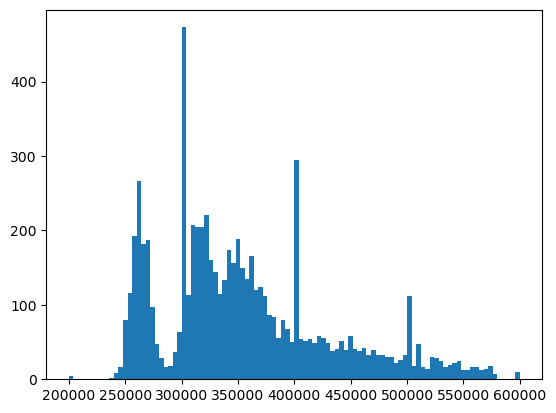

In [119]:
plt.hist(df_all["MonthlyIncome"].values, bins=100)
plt.show()

## customer_info

In [121]:
map_sep_char = {
    "　": " ",
    "／": " ",
    "、": " ",
    "/": " ",
    ",": " ",
    "-": " ",
    "ー": " ",
    "\n": " ",
    "\t": " ",
    }

map_car_char = {
    "車未所持": "未所有",
    "車所持": "所有",
    "自動車未所有": "未所有",
    "自動車所有": "所有",
    "自家用車なし": "未所有",
    "自家用車あり": "所有",
    "乗用車なし": "未所有",
    "乗用車所持": "所有",
    "車なし": "未所有",
    "車保有なし": "未所有",
    "車保有": "所有",
    "車あり": "所有",
}

map_child_char = {
    '子供1人': '1',
    '子供なし': '0',
    '子供2人': '2',
    'こども1人': '1',
    '子供無し': '0',
    'こども2人': '2',
    '子供有り': '有り',
    '1児': '1',
    '子供有り(1人)': '1',
    '子供ゼロ': '0',
    '無子': '0',
    '非育児家庭': '0',
    '子供有り(2人)': '2',
    '2児': '2',
    '子供3人': '3',
    '子供の数不明': '不明',
    'こども3人': '3',
    '不明': '不明',
    '3児': '3',
    '子育て状況不明': '不明',
    '子供有り(3人)': '3',
    '子の数不詳': '不明',
    'わからない': '不明'
 }

def replace_sep_char(text):
    result = []
    for c in text:
        result.append(map_sep_char.get(c, c))
    return "".join(result)

def replace_car(text):
    if text is np.nan:
        return text
    else:
        return map_car_char.get(text)
    
def replace_child(text):
    if text is np.nan:
        return text
    else:
        return map_child_char.get(text)
    
def devide_customer_info(df, col):
    df[col] = df[col].apply(replace_sep_char)
    df["marry"] = df[col].apply(lambda x: x.split(" ")[0])
    df["car"] = df[col].apply(lambda x: x.split(" ")[1])
    df["child"] = df[col].apply(lambda x: x.split(" ")[2])
    df["car"] = df["car"].apply(replace_car)
    df["child"] = df["child"].apply(replace_child)
    return df

In [122]:
df_all = devide_customer_info(df_all, "customer_info")

In [123]:
df_all["marry"].value_counts()

marry
結婚済み    2846
離婚済み    1688
独身      1309
未婚      1135
Name: count, dtype: int64

In [124]:
df_all["car"].value_counts()

car
未所有    3619
所有     3359
Name: count, dtype: int64

In [125]:
df_all["child"].value_counts()

child
1     2945
0     1909
2     1600
有り     321
3      129
不明      74
Name: count, dtype: int64

## データ出力

In [ ]:
df_all.to_pickle(os.path.join(DIR_INTERIM, "preprocessed.pkl"))

# 特徴量作成

In [43]:
df_preprocessed = pd.read_pickle(os.path.join(DIR_INTERIM, "preprocessed.pkl"))

In [6]:
from pathlib import Path
from abc import ABCMeta, abstractmethod

In [7]:
from time import time

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20
        
    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [8]:
class AbstractBaseBlock(metaclass=ABCMeta):

    def __init__(self, use_cache=False, save_cache=False, logger=None):
        self.use_cache = use_cache
        self.name = self.__class__.__name__
        self.cache_dir = Path(DIR_FEATURE)
        self.logger = logger
        self.seve_cache = save_cache
        self.use_cols = None
        
    # 内部状態の更新
    def fit(self, df_input: pd.DataFrame, y=None):
        pass
    
    # 変換処理
    @abstractmethod
    def transform(self, df_input: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()
    
    # 内部状態の更新と変換処理をまとめて行う
    def fit_transform(self, df_input: pd.DataFrame, y=None):
        self.fit(df_input, y)
        return self.transform(df_input)
    
    # 特徴量生成処理
    def create_feature(self, df_input, y=None, test=False) -> pd.DataFrame:

        # クラス名.pkl
        file_name = self.cache_dir / f"{self.name}.pkl"

        # キャッシュを使う & ファイルがあるなら読み出し
        if os.path.isfile(str(file_name)) and self.use_cache:
            return pd.read_pickle(file_name)
        # 変換処理を実行
        else:
            # trainの場合
            if not test:
                feature = self.fit_transform(df_input, y)
            # testの場合
            else:
                feature = self.transform(df_input)
            # 保存する場合
            if self.seve_cache:
                feature.to_pickle(file_name)

            return feature

In [9]:
 # そのままのデータはpreprocessedデータから取得する

In [59]:
# カテゴリ変数を抽出する
df_preprocessed.select_dtypes(include=["object"]).columns
# 数値変数を抽出する
df_preprocessed.select_dtypes(include=["int64", "float64"]).columns

Index(['index', 'id', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'MonthlyIncome', 'ProdTaken'],
      dtype='object')

In [209]:
class AsIsNumetricBlock(AbstractBaseBlock):

    def __init__(self, use_cache=False, save_cache=False, logger=None):
        super().__init__(use_cache, save_cache, logger)
        self.use_cols = [
            'CityTier', 
            'DurationOfPitch',
            'NumberOfPersonVisiting',
            'NumberOfFollowups', 
            'PreferredPropertyStar', 
            'NumberOfTrips',
            'Passport', 
            'PitchSatisfactionScore',
            'MonthlyIncome', 
            'ProdTaken' # 目的関数
        ]
        self.key_col = ["id"]
        self.map_count = None

    def transform(self, df_input):
        df_out = pd.DataFrame()
        df_out = df_input[self.key_col + self.use_cols]
        return df_out

class AsIsCategoryBlock(AbstractBaseBlock):

    def __init__(self, use_cache=False, save_cache=False, logger=None):
        super().__init__(use_cache, save_cache, logger)
        self.use_cols = [
            'Age', 
            'TypeofContact',
            'Occupation',
            'Gender',
            'ProductPitched',
            'Designation', 
            'customer_info', 
            'marry', 
            'car', 
            'child',
        ]
        self.key_col = ["id"]
        self.map_count = None

    def transform(self, df_input):
        df_out = pd.DataFrame()
        df_out = df_input[self.key_col + self.use_cols]
        return df_out

In [73]:
class CountEncodingBlock(AbstractBaseBlock):

    def __init__(self, use_cache=False, save_cache=False, logger=None):
        super().__init__(use_cache, save_cache, logger)
        self.use_cols = [
            "TypeofContact", "CityTier", "Occupation", "ProductPitched",
            "Designation", "marry", "car"
        ]
        self.key_col = ["id"]
        self.map_count = None

    def fit(self, df_input, y=None):
        # カラムごとにマッピング表を作成
        self.map_count = {}
        for col in self.use_cols:
            self.map_count[col] = df_input[col].fillna("NA").value_counts()

    def transform(self, df_input):
        df_out = pd.DataFrame()
        df_out[self.key_col] = df_input[self.key_col]
        for col in self.use_cols:
            df_out[col] = df_input[col].fillna("NA").map(self.map_count[col]).astype(int)
        # id以外のカラム名に接頭辞を付ける
        df_result = pd.concat([df_out[self.key_col], df_out.drop(columns=self.key_col).add_prefix('CE_')], axis=1)
        return df_result
        
class TargetEncodingBlock(AbstractBaseBlock):

    def __init__(self, use_cache=False, save_cache=False, logger=None):
        super().__init__(use_cache, save_cache, logger)
        self.use_cols = [
            "TypeofContact", "CityTier", "Occupation", "ProductPitched",
            "Designation", "marry", "car"
        ]
        self.key_col = ["id"]
        self.map_target = None

    def fit(self, df_input, y):
        # カラムごとにマッピング表を作成
        self.map_target = {}
        for col in self.use_cols:
            self.map_target[col] = df_input.groupby(col)[TARGET_COL].mean()

    def transform(self, df_input):
        df_out = pd.DataFrame()
        df_out[self.key_col] = df_input[self.key_col]
        for col in self.use_cols:
            df_out[col] = df_input[col].map(self.map_target[col]).astype(float)
        # id以外のカラム名に接頭辞を付ける
        df_result = pd.concat([df_out[self.key_col], df_out.drop(columns=self.key_col).add_prefix('TE_')], axis=1)
        return df_result
    
# 大分類を作成するクラス
class BigCategoryBlock(AbstractBaseBlock):

    def __init__(self, use_cache=False, save_cache=False, logger=None):
        super().__init__(use_cache, save_cache, logger)
        self.use_cols = []
        self.key_col = ["id"]
        self.map_target = None

    def fit(self, df_input, y=None):
        pass

    def transform(self, df_input):
        df_out = pd.DataFrame()
        df_out[self.key_col] = df_input[self.key_col]
        df_out["Age"] = df_input["Age"].apply(lambda x: self.replace_sai_to_dai(x) if not pd.isna(x) else x)
        # id以外のカラム名に接頭辞を付ける
        df_result = pd.concat([df_out[self.key_col], df_out.drop(columns=self.key_col).add_prefix('BC_')], axis=1)
        return df_result
    
    def replace_sai_to_dai(self, age):
        first_char = age[0]
        if first_char == "1":
            result = "10代"
        elif first_char == "2":
            result = "20代"
        elif first_char == "3":
            result = "30代"
        elif first_char == "4":
            result = "40代"
        elif first_char == "5":
            result = "50代"
        elif first_char == "6":
            result = "60代"
        return result
    
# 大分類を作成するクラス
class BigCategoryBlock(AbstractBaseBlock):

    def __init__(self, use_cache=False, save_cache=False, logger=None):
        super().__init__(use_cache, save_cache, logger)
        self.use_cols = []
        self.key_col = ["id"]
        self.map_target = None

    def fit(self, df_input, y=None):
        pass

    def transform(self, df_input):
        df_out = pd.DataFrame()
        df_out[self.key_col] = df_input[self.key_col]
        df_out["Age"] = df_input["Age"].apply(lambda x: self.replace_sai_to_dai(x) if not pd.isna(x) else x)
        # id以外のカラム名に接頭辞を付ける
        df_result = pd.concat([df_out[self.key_col], df_out.drop(columns=self.key_col).add_prefix('BC_')], axis=1)
        return df_result
    
    def replace_sai_to_dai(self, age):
        first_char = age[0]
        if first_char == "1":
            result = "10代"
        elif first_char == "2":
            result = "20代"
        elif first_char == "3":
            result = "30代"
        elif first_char == "4":
            result = "40代"
        elif first_char == "5":
            result = "50代"
        elif first_char == "6":
            result = "60代"
        return result

In [75]:
def run_blocks(df_input, feature_blocks, y=None, test=False):
    df_out = None
    
    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)):
        for block in feature_blocks:
            with Timer(prefix='\t- {}'.format(str(block))):
                feature = block.create_feature(df_input, y=y, test=test)
            assert len(df_input) == len(feature), block
            if df_out is None:
                df_out = feature
            else:
                df_out = pd.merge(df_out, feature, on=["id"], how="left")

    return df_out

In [210]:
feature_blocks = [
    *[AsIsCategoryBlock(use_cache=False, save_cache=True, logger=None)],
    *[AsIsNumetricBlock(use_cache=True, save_cache=True, logger=None)],
    *[CountEncodingBlock(use_cache=True, save_cache=True, logger=None)],
    *[TargetEncodingBlock(use_cache=True, save_cache=True, logger=None)],
    *[BigCategoryBlock(use_cache=True, save_cache=True, logger=None)],
]

In [211]:
df_preprocessed = pd.read_pickle(os.path.join(DIR_INTERIM, "preprocessed.pkl"))

In [212]:
df_out = run_blocks(df_preprocessed, feature_blocks, y=None, test=False)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.AsIsCategoryBlock object at 0x7fd57ad0a400> 0.034[s]
	- <__main__.AsIsNumetricBlock object at 0x7fd57ad0a8b0> 0.004[s]
	- <__main__.CountEncodingBlock object at 0x7fd57ad0a8e0> 0.002[s]
	- <__main__.TargetEncodingBlock object at 0x7fd57ad0a940> 0.001[s]
	- <__main__.BigCategoryBlock object at 0x7fd57ad0ac70> 0.001[s]
run test=False 0.069[s]


# モデル構築

In [180]:
import sys
from datetime import datetime
sys.path.append("/Users/ishizuka/pyworks/Competitions/signate_signatecup2024")
from src.model_lgb import ModelLGB
from src.runner import Runner
from src.util import Logger
from sklearn.preprocessing import LabelEncoder

In [304]:
import importlib
from src import runner
from src import model_lgb

# runnerモジュールをリロード
importlib.reload(runner)
importlib.reload(model_lgb)

# Runnerクラスを再インポート
from src.runner import Runner
from src.model_lgb import ModelLGB

In [184]:
def transform_object_to_category(df):
    object_columns = df.select_dtypes(include=['object']).columns
    for col in object_columns:
        print(f"transform: {col}")
        df.loc[:, col] = df[col].astype('category')
    return df

def label_encoding(df):

    # カテゴリ変数のカラムを抽出
    obj_cols = df.dtypes[df.dtypes=="object"].index

    for col in obj_cols:
        df[col] = LabelEncoder().fit_transform(df[col])

    return df

In [187]:
def get_run_name(model_type):
    """run名の作成
    """
    run_name = model_type
    suffix = '_' + datetime.now().strftime("%Y%m%d%H%M")
    run_name = run_name + suffix
    return run_name

In [186]:
logger = Logger(path=DIR_LOG)

In [214]:
# 特徴量生成
list_feat_train = []
list_feat_train.append(pd.read_pickle(os.path.join(DIR_FEATURE, "AsIsCategoryBlock.pkl")))
list_feat_train.append(pd.read_pickle(os.path.join(DIR_FEATURE, "AsIsNumetricBlock.pkl")))
list_feat_train.append(pd.read_pickle(os.path.join(DIR_FEATURE, "CountEncodingBlock.pkl")))
# list_feat_train.append(pd.read_pickle(os.path.join(DIR_FEATURE, "TargetEncodingBlock.pkl")))
# list_feat_train.append(pd.read_pickle(os.path.join(DIR_FEATURE, "BigCategoryBlock.pkl")))

list_feat_test = []
list_feat_test.append(pd.read_pickle(os.path.join(DIR_FEATURE, "AsIsCategoryBlock.pkl")))
list_feat_test.append(pd.read_pickle(os.path.join(DIR_FEATURE, "AsIsNumetricBlock.pkl")))
list_feat_test.append(pd.read_pickle(os.path.join(DIR_FEATURE, "CountEncodingBlock.pkl")))
list_feat_test.append(pd.read_pickle(os.path.join(DIR_FEATURE, "TargetEncodingBlock.pkl")))
# list_feat_test.append(pd.read_pickle(os.path.join(DIR_FEATURE, "BigCategoryBlock.pkl")))


In [215]:
# キー
df_key = pd.read_pickle(os.path.join(DIR_INTERIM, "preprocessed.pkl"))[["id"]]
len_train = len(pd.read_csv(os.path.join(DIR_RAW_DATA, FILE_NAME_TRAIN)))
df_key_train = df_key.iloc[:len_train]
df_key_test = df_key.iloc[len_train:]

In [216]:
df_feature_train = df_key_train.copy()
df_feature_test = df_key_test.copy()
for df_feat_ in list_feat_train:
    df_feature_train = pd.merge(df_feature_train, df_feat_, on="id", how="left")
for df_feat_ in list_feat_test:
    df_feature_test = pd.merge(df_feature_test, df_feat_, on="id", how="left")

In [217]:
df_train = transform_object_to_category(df_feature_train)
df_train = label_encoding(df_train)

df_test = transform_object_to_category(df_feature_test)
df_test = label_encoding(df_test)
df_test.drop(columns=[TARGET_COL], inplace=True)

transform: Age
transform: TypeofContact
transform: Occupation
transform: Gender
transform: ProductPitched
transform: Designation
transform: customer_info
transform: marry
transform: car
transform: child
transform: Age
transform: TypeofContact
transform: Occupation
transform: Gender
transform: ProductPitched
transform: Designation
transform: customer_info
transform: marry
transform: car
transform: child


In [300]:
# lightgbmのパラメータ
params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "binary_logloss",
        "learning_rate": 0.1,
        "num_leaves": 31,
        "colsample_bytree": 0.5, # feature_fraction
        "subsample": 0.5,
        "reg_lambda": 5,
        "random_state": 71,
        'max_depth': 3,
        "min_data_in_leaf": 10,
        "num_leaves": 31,
        "num_boost_round": 5000,
        "early_stopping_rounds": 100,
        "verbose": False,
        "period": 100,
        'verbosity': -1,  # 出力を抑制
    }
run_setting = {
    "key": KEY_COL,       # データセットのID
    'calc_shap': False,     # shap値を計算するか否か
    'save_train_pred': False,    # trainデータに対する予測値を保存するか否か(閾値の最適化に使用)
    "tune_params": True,           # パラメータチューニング、lgb_hopt,xgb_hopt,nn_hopt,False
    "target_encoder": TargetEncodingBlock(use_cache=False),     # target encodingをしない場合はNone
    }

In [301]:
run_name = get_run_name(model_type="lgb")
run_name

'lgb_202409020017'

In [305]:
# runnerクラスをインスタンス化
memo = "optuna full"
runner = Runner(run_name, ModelLGB, params, df_train, df_test, run_setting, logger, memo)

In [307]:
runner.run_train_cv()

[2024-09-02 00:22:06] - lgb_202409020017 - start training cv
[2024-09-02 00:22:06] - lgb_202409020017 fold 0 - start training
[2024-09-02 00:22:06] - lgb_202409020017 - start tuning
[I 2024-09-02 00:22:06,117] A new study created in memory with name: no-name-d5fafe34-26e5-473d-8d40-6ae473c38430


[100]	train's binary_logloss: 0.05664	train's AUC: 0.999997	eval's binary_logloss: 0.471949	eval's AUC: 0.766212


[I 2024-09-02 00:22:06,943] Trial 0 finished with value: 0.7895715630885123 and parameters: {'num_leaves': 187, 'max_depth': 9, 'learning_rate': 0.3117958932426573, 'subsample': 0.7669745220034819, 'min_data_in_leaf': 73, 'reg_alpha': 0.6487143462495427, 'reg_lambda': 0.23478032062842188}. Best is trial 0 with value: 0.7895715630885123.


[100]	train's binary_logloss: 0.187495	train's AUC: 0.952415	eval's binary_logloss: 0.396982	eval's AUC: 0.787837


[I 2024-09-02 00:22:08,164] Trial 1 finished with value: 0.7910703075957314 and parameters: {'num_leaves': 97, 'max_depth': 2, 'learning_rate': 0.8403134228592632, 'subsample': 0.9085489827172918, 'min_data_in_leaf': 87, 'reg_alpha': 0.18121354560729608, 'reg_lambda': 0.5732077396444388}. Best is trial 1 with value: 0.7910703075957314.


[100]	train's binary_logloss: 0.085001	train's AUC: 0.998796	eval's binary_logloss: 0.480588	eval's AUC: 0.77048


[I 2024-09-02 00:22:08,870] Trial 2 finished with value: 0.7731167608286251 and parameters: {'num_leaves': 109, 'max_depth': 8, 'learning_rate': 0.7561224598544087, 'subsample': 0.3099123428398269, 'min_data_in_leaf': 187, 'reg_alpha': 0.7764694826739118, 'reg_lambda': 0.8541893005001084}. Best is trial 1 with value: 0.7910703075957314.


[100]	train's binary_logloss: 0.116958	train's AUC: 0.990567	eval's binary_logloss: 0.47162	eval's AUC: 0.760797


[I 2024-09-02 00:22:09,551] Trial 3 finished with value: 0.8006591337099812 and parameters: {'num_leaves': 45, 'max_depth': 3, 'learning_rate': 0.8000604565010052, 'subsample': 0.05740339496526772, 'min_data_in_leaf': 76, 'reg_alpha': 0.5236495042349432, 'reg_lambda': 0.5677762453994923}. Best is trial 3 with value: 0.8006591337099812.


[100]	train's binary_logloss: 0.270108	train's AUC: 0.881583	eval's binary_logloss: 0.341213	eval's AUC: 0.811331


[I 2024-09-02 00:22:10,484] Trial 4 finished with value: 0.8109855618330194 and parameters: {'num_leaves': 3, 'max_depth': 7, 'learning_rate': 0.1299557462640464, 'subsample': 0.2528116059938761, 'min_data_in_leaf': 15, 'reg_alpha': 0.20238661816842443, 'reg_lambda': 0.8621074432899766}. Best is trial 4 with value: 0.8109855618330194.


[100]	train's binary_logloss: 0.0479034	train's AUC: 0.999997	eval's binary_logloss: 0.539096	eval's AUC: 0.749027


[I 2024-09-02 00:22:11,189] Trial 5 finished with value: 0.7736660389202761 and parameters: {'num_leaves': 51, 'max_depth': 4, 'learning_rate': 0.7308409919808807, 'subsample': 0.6711944437904719, 'min_data_in_leaf': 2, 'reg_alpha': 0.9725422696320929, 'reg_lambda': 0.9907456916104096}. Best is trial 4 with value: 0.8109855618330194.


[100]	train's binary_logloss: 0.0146622	train's AUC: 1	eval's binary_logloss: 0.533213	eval's AUC: 0.77704


[I 2024-09-02 00:22:11,916] Trial 6 finished with value: 0.7695072190834902 and parameters: {'num_leaves': 242, 'max_depth': 9, 'learning_rate': 0.418450872289334, 'subsample': 0.6117434575235823, 'min_data_in_leaf': 18, 'reg_alpha': 0.3551978433342781, 'reg_lambda': 0.4564206245842491}. Best is trial 4 with value: 0.8109855618330194.


[100]	train's binary_logloss: 0.244103	train's AUC: 0.910309	eval's binary_logloss: 0.351266	eval's AUC: 0.802872


[I 2024-09-02 00:22:12,960] Trial 7 finished with value: 0.8064344005021972 and parameters: {'num_leaves': 121, 'max_depth': 2, 'learning_rate': 0.2458230009882197, 'subsample': 0.2041107078495441, 'min_data_in_leaf': 65, 'reg_alpha': 0.8155631344552443, 'reg_lambda': 0.05299196888595916}. Best is trial 4 with value: 0.8109855618330194.


[100]	train's binary_logloss: 0.207611	train's AUC: 0.951441	eval's binary_logloss: 0.352658	eval's AUC: 0.800016


[I 2024-09-02 00:22:13,858] Trial 8 finished with value: 0.8051475204017577 and parameters: {'num_leaves': 206, 'max_depth': 8, 'learning_rate': 0.09307853492354391, 'subsample': 0.6472188424361885, 'min_data_in_leaf': 127, 'reg_alpha': 0.8141540414276975, 'reg_lambda': 0.717864788977547}. Best is trial 4 with value: 0.8109855618330194.


[100]	train's binary_logloss: 0.1424	train's AUC: 0.98481	eval's binary_logloss: 0.391726	eval's AUC: 0.791839


[I 2024-09-02 00:22:14,585] Trial 9 finished with value: 0.7995134965473948 and parameters: {'num_leaves': 190, 'max_depth': 9, 'learning_rate': 0.37937551215491944, 'subsample': 0.20017066200149877, 'min_data_in_leaf': 194, 'reg_alpha': 0.719733960656301, 'reg_lambda': 0.6580677536053556}. Best is trial 4 with value: 0.8109855618330194.
[2024-09-02 00:22:14] - lgb_202409020017 - end tuning


[100]	train's binary_logloss: 0.270108	train's AUC: 0.881583	eval's binary_logloss: 0.341213	eval's AUC: 0.811331


[2024-09-02 00:22:15] - lgb_202409020017 fold 0 - end training - score 0.8109855618330194
[2024-09-02 00:22:15] - lgb_202409020017 fold 1 - start training
[2024-09-02 00:22:15] - lgb_202409020017 - start tuning
[I 2024-09-02 00:22:15,588] A new study created in memory with name: no-name-cec0c63f-db63-4160-a1bd-26b15c01e7d6


[100]	train's binary_logloss: 0.296917	train's AUC: 0.85784	eval's binary_logloss: 0.285606	eval's AUC: 0.837309
[200]	train's binary_logloss: 0.290477	train's AUC: 0.864632	eval's binary_logloss: 0.285192	eval's AUC: 0.836239


[I 2024-09-02 00:22:16,633] Trial 0 finished with value: 0.8375675725540119 and parameters: {'num_leaves': 149, 'max_depth': 1, 'learning_rate': 0.21567372135825538, 'subsample': 0.35550660167641224, 'min_data_in_leaf': 119, 'reg_alpha': 0.47392833366324055, 'reg_lambda': 0.9492867234153884}. Best is trial 0 with value: 0.8375675725540119.


[100]	train's binary_logloss: 0.336544	train's AUC: 0.830387	eval's binary_logloss: 0.314356	eval's AUC: 0.821821
[200]	train's binary_logloss: 0.319124	train's AUC: 0.84104	eval's binary_logloss: 0.30006	eval's AUC: 0.829339
[300]	train's binary_logloss: 0.310903	train's AUC: 0.846737	eval's binary_logloss: 0.292903	eval's AUC: 0.834726
[400]	train's binary_logloss: 0.306036	train's AUC: 0.850126	eval's binary_logloss: 0.289153	eval's AUC: 0.837106
[500]	train's binary_logloss: 0.302787	train's AUC: 0.852532	eval's binary_logloss: 0.287358	eval's AUC: 0.838259
[600]	train's binary_logloss: 0.300419	train's AUC: 0.854808	eval's binary_logloss: 0.28624	eval's AUC: 0.838896
[700]	train's binary_logloss: 0.298562	train's AUC: 0.856655	eval's binary_logloss: 0.285835	eval's AUC: 0.838628


[I 2024-09-02 00:22:18,826] Trial 1 finished with value: 0.8390804597701149 and parameters: {'num_leaves': 165, 'max_depth': 1, 'learning_rate': 0.027385169230483026, 'subsample': 0.06426924106443829, 'min_data_in_leaf': 60, 'reg_alpha': 0.6644549019910428, 'reg_lambda': 0.8585455775081922}. Best is trial 1 with value: 0.8390804597701149.


[100]	train's binary_logloss: 0.208166	train's AUC: 0.942181	eval's binary_logloss: 0.299036	eval's AUC: 0.827955


[I 2024-09-02 00:22:19,924] Trial 2 finished with value: 0.8325861146473312 and parameters: {'num_leaves': 58, 'max_depth': 2, 'learning_rate': 0.6759369676520983, 'subsample': 0.7318140279494053, 'min_data_in_leaf': 34, 'reg_alpha': 0.9991748297403961, 'reg_lambda': 0.41384258373875665}. Best is trial 1 with value: 0.8390804597701149.


[100]	train's binary_logloss: 0.0319896	train's AUC: 1	eval's binary_logloss: 0.406132	eval's AUC: 0.798546


[I 2024-09-02 00:22:20,824] Trial 3 finished with value: 0.8225770742237228 and parameters: {'num_leaves': 86, 'max_depth': 5, 'learning_rate': 0.5807463301742782, 'subsample': 0.7985829395181211, 'min_data_in_leaf': 29, 'reg_alpha': 0.41311479003390733, 'reg_lambda': 0.6630622240930857}. Best is trial 1 with value: 0.8390804597701149.


[100]	train's binary_logloss: 0.0761905	train's AUC: 0.999913	eval's binary_logloss: 0.310824	eval's AUC: 0.827586


[I 2024-09-02 00:22:22,410] Trial 4 finished with value: 0.8282873009723067 and parameters: {'num_leaves': 69, 'max_depth': 8, 'learning_rate': 0.18765693883126597, 'subsample': 0.8721668077732545, 'min_data_in_leaf': 38, 'reg_alpha': 0.46252204576895045, 'reg_lambda': 0.7217288696951653}. Best is trial 1 with value: 0.8390804597701149.


[100]	train's binary_logloss: 0.200492	train's AUC: 0.957345	eval's binary_logloss: 0.297529	eval's AUC: 0.826332


[I 2024-09-02 00:22:23,397] Trial 5 finished with value: 0.8278076050257376 and parameters: {'num_leaves': 110, 'max_depth': 4, 'learning_rate': 0.2188464892436209, 'subsample': 0.7043365958912697, 'min_data_in_leaf': 102, 'reg_alpha': 0.8443013107578416, 'reg_lambda': 0.39617939358568527}. Best is trial 1 with value: 0.8390804597701149.


[100]	train's binary_logloss: 0.0601009	train's AUC: 0.999884	eval's binary_logloss: 0.397827	eval's AUC: 0.798066


[I 2024-09-02 00:22:24,186] Trial 6 finished with value: 0.8268851128207967 and parameters: {'num_leaves': 121, 'max_depth': 6, 'learning_rate': 0.7433944514472249, 'subsample': 0.7888452064001183, 'min_data_in_leaf': 122, 'reg_alpha': 0.4103415753539931, 'reg_lambda': 0.8486021607653098}. Best is trial 1 with value: 0.8390804597701149.


[100]	train's binary_logloss: 0.1232	train's AUC: 0.991785	eval's binary_logloss: 0.314821	eval's AUC: 0.817033


[I 2024-09-02 00:22:24,973] Trial 7 finished with value: 0.8392649582111031 and parameters: {'num_leaves': 218, 'max_depth': 4, 'learning_rate': 0.36373074518769366, 'subsample': 0.13238375871092703, 'min_data_in_leaf': 51, 'reg_alpha': 0.19581006645088986, 'reg_lambda': 0.34429393708638256}. Best is trial 7 with value: 0.8392649582111031.


[100]	train's binary_logloss: 0.292181	train's AUC: 0.862303	eval's binary_logloss: 0.286051	eval's AUC: 0.83373


[I 2024-09-02 00:22:25,818] Trial 8 finished with value: 0.8375583476319624 and parameters: {'num_leaves': 220, 'max_depth': 1, 'learning_rate': 0.35810119512294164, 'subsample': 0.08066408912880807, 'min_data_in_leaf': 162, 'reg_alpha': 0.8663590981274366, 'reg_lambda': 0.5923382939972419}. Best is trial 7 with value: 0.8392649582111031.


[100]	train's binary_logloss: 0.150407	train's AUC: 0.981623	eval's binary_logloss: 0.306392	eval's AUC: 0.831571


[I 2024-09-02 00:22:26,922] Trial 9 finished with value: 0.8383424660061622 and parameters: {'num_leaves': 247, 'max_depth': 4, 'learning_rate': 0.41631159120444144, 'subsample': 0.7249671506933765, 'min_data_in_leaf': 101, 'reg_alpha': 0.28078312075208633, 'reg_lambda': 0.4071903501495729}. Best is trial 7 with value: 0.8392649582111031.
[2024-09-02 00:22:26] - lgb_202409020017 - end tuning


[100]	train's binary_logloss: 0.1232	train's AUC: 0.991785	eval's binary_logloss: 0.314821	eval's AUC: 0.817033


[2024-09-02 00:22:28] - lgb_202409020017 fold 1 - end training - score 0.8392649582111031
[2024-09-02 00:22:28] - lgb_202409020017 fold 2 - start training
[2024-09-02 00:22:28] - lgb_202409020017 - start tuning
[I 2024-09-02 00:22:28,268] A new study created in memory with name: no-name-d931df6a-0e7a-48b2-98c0-c2578a8a5cc1


[100]	train's binary_logloss: 0.148713	train's AUC: 0.980782	eval's binary_logloss: 0.387854	eval's AUC: 0.788663


[I 2024-09-02 00:22:29,183] Trial 0 finished with value: 0.8035889016037282 and parameters: {'num_leaves': 117, 'max_depth': 3, 'learning_rate': 0.6325025360186748, 'subsample': 0.729109516907987, 'min_data_in_leaf': 84, 'reg_alpha': 0.9167479660042412, 'reg_lambda': 0.36905525285509055}. Best is trial 0 with value: 0.8035889016037282.


[100]	train's binary_logloss: 0.075769	train's AUC: 0.999144	eval's binary_logloss: 0.4291	eval's AUC: 0.793041


[I 2024-09-02 00:22:29,957] Trial 1 finished with value: 0.7981408693633183 and parameters: {'num_leaves': 184, 'max_depth': 7, 'learning_rate': 0.7107854027660998, 'subsample': 0.27040252662355696, 'min_data_in_leaf': 141, 'reg_alpha': 0.8505127093318722, 'reg_lambda': 0.6196682428834595}. Best is trial 0 with value: 0.8035889016037282.


[100]	train's binary_logloss: 0.262338	train's AUC: 0.896122	eval's binary_logloss: 0.33211	eval's AUC: 0.811317
[200]	train's binary_logloss: 0.235348	train's AUC: 0.922215	eval's binary_logloss: 0.332762	eval's AUC: 0.817487


[I 2024-09-02 00:22:31,065] Trial 2 finished with value: 0.8140703517587939 and parameters: {'num_leaves': 36, 'max_depth': 3, 'learning_rate': 0.05719831961826058, 'subsample': 0.2667684037898212, 'min_data_in_leaf': 21, 'reg_alpha': 0.6662885524163731, 'reg_lambda': 0.5263002080190955}. Best is trial 2 with value: 0.8140703517587939.


[100]	train's binary_logloss: 0.153942	train's AUC: 0.977716	eval's binary_logloss: 0.37389	eval's AUC: 0.792991


[I 2024-09-02 00:22:32,149] Trial 3 finished with value: 0.815065426140604 and parameters: {'num_leaves': 234, 'max_depth': 3, 'learning_rate': 0.590075741234874, 'subsample': 0.3104069569964396, 'min_data_in_leaf': 70, 'reg_alpha': 0.4721273510795227, 'reg_lambda': 0.9156465478939655}. Best is trial 3 with value: 0.815065426140604.


[100]	train's binary_logloss: 0.0251916	train's AUC: 1	eval's binary_logloss: 0.589476	eval's AUC: 0.767501


[I 2024-09-02 00:22:32,881] Trial 4 finished with value: 0.776779939300463 and parameters: {'num_leaves': 171, 'max_depth': 7, 'learning_rate': 0.9272031108203912, 'subsample': 0.6769902338372014, 'min_data_in_leaf': 123, 'reg_alpha': 0.1182791829431093, 'reg_lambda': 0.941687614906757}. Best is trial 3 with value: 0.815065426140604.


[100]	train's binary_logloss: 0.0327038	train's AUC: 1	eval's binary_logloss: 0.459129	eval's AUC: 0.807685


[I 2024-09-02 00:22:33,615] Trial 5 finished with value: 0.7816392191983018 and parameters: {'num_leaves': 158, 'max_depth': 6, 'learning_rate': 0.723753155400047, 'subsample': 0.2249319724559983, 'min_data_in_leaf': 18, 'reg_alpha': 0.9233463469219231, 'reg_lambda': 0.2954504326011502}. Best is trial 3 with value: 0.815065426140604.


[100]	train's binary_logloss: 0.220286	train's AUC: 0.943216	eval's binary_logloss: 0.337196	eval's AUC: 0.810223


[I 2024-09-02 00:22:34,621] Trial 6 finished with value: 0.8059936646931024 and parameters: {'num_leaves': 221, 'max_depth': 9, 'learning_rate': 0.07149957106228771, 'subsample': 0.38055893544850344, 'min_data_in_leaf': 122, 'reg_alpha': 0.16126714482022386, 'reg_lambda': 0.6809016048912101}. Best is trial 3 with value: 0.815065426140604.


[100]	train's binary_logloss: 0.114335	train's AUC: 0.992155	eval's binary_logloss: 0.448526	eval's AUC: 0.763521


[I 2024-09-02 00:22:35,403] Trial 7 finished with value: 0.8091779027148946 and parameters: {'num_leaves': 73, 'max_depth': 6, 'learning_rate': 0.7569335793889237, 'subsample': 0.7247562041732817, 'min_data_in_leaf': 244, 'reg_alpha': 0.01164108067916093, 'reg_lambda': 0.6631890434407393}. Best is trial 3 with value: 0.815065426140604.


[100]	train's binary_logloss: 0.0963939	train's AUC: 0.997434	eval's binary_logloss: 0.412511	eval's AUC: 0.788746


[I 2024-09-02 00:22:36,284] Trial 8 finished with value: 0.7854702555682702 and parameters: {'num_leaves': 209, 'max_depth': 7, 'learning_rate': 0.4234484532809044, 'subsample': 0.3414175139407679, 'min_data_in_leaf': 132, 'reg_alpha': 0.6638490202988432, 'reg_lambda': 0.13884893381788865}. Best is trial 3 with value: 0.815065426140604.


[100]	train's binary_logloss: 0.217071	train's AUC: 0.936193	eval's binary_logloss: 0.354494	eval's AUC: 0.793505


[I 2024-09-02 00:22:37,161] Trial 9 finished with value: 0.8072375076703651 and parameters: {'num_leaves': 175, 'max_depth': 2, 'learning_rate': 0.5630672620918801, 'subsample': 0.034388271824924904, 'min_data_in_leaf': 111, 'reg_alpha': 0.3550803961145512, 'reg_lambda': 0.21638257068764796}. Best is trial 3 with value: 0.815065426140604.
[2024-09-02 00:22:37] - lgb_202409020017 - end tuning


[100]	train's binary_logloss: 0.153942	train's AUC: 0.977716	eval's binary_logloss: 0.37389	eval's AUC: 0.792991


[2024-09-02 00:22:37] - lgb_202409020017 fold 2 - end training - score 0.815065426140604
[2024-09-02 00:22:37] - lgb_202409020017 fold 3 - start training
[2024-09-02 00:22:37] - lgb_202409020017 - start tuning
[I 2024-09-02 00:22:37,988] A new study created in memory with name: no-name-928e7afd-c15e-48fa-a6d5-5c91627f862e


[100]	train's binary_logloss: 0.273401	train's AUC: 0.882546	eval's binary_logloss: 0.28457	eval's AUC: 0.865019
[200]	train's binary_logloss: 0.248877	train's AUC: 0.909211	eval's binary_logloss: 0.28158	eval's AUC: 0.869187


[I 2024-09-02 00:22:39,318] Trial 0 finished with value: 0.8712798257200199 and parameters: {'num_leaves': 78, 'max_depth': 2, 'learning_rate': 0.1590129554372292, 'subsample': 0.4624027759489057, 'min_data_in_leaf': 59, 'reg_alpha': 0.42350281016271574, 'reg_lambda': 0.33839006754495654}. Best is trial 0 with value: 0.8712798257200199.


[100]	train's binary_logloss: 0.182641	train's AUC: 0.966186	eval's binary_logloss: 0.297018	eval's AUC: 0.856236


[I 2024-09-02 00:22:40,348] Trial 1 finished with value: 0.8694787038784156 and parameters: {'num_leaves': 125, 'max_depth': 7, 'learning_rate': 0.4321428906530593, 'subsample': 0.12089884161493754, 'min_data_in_leaf': 253, 'reg_alpha': 0.5406679593854006, 'reg_lambda': 0.7751330400556129}. Best is trial 0 with value: 0.8712798257200199.


[100]	train's binary_logloss: 0.0751818	train's AUC: 0.999649	eval's binary_logloss: 0.36824	eval's AUC: 0.829254


[I 2024-09-02 00:22:41,171] Trial 2 finished with value: 0.8594267286481294 and parameters: {'num_leaves': 16, 'max_depth': 7, 'learning_rate': 0.5154317158255017, 'subsample': 0.9525563816027167, 'min_data_in_leaf': 114, 'reg_alpha': 0.361230390365917, 'reg_lambda': 0.9061161415919472}. Best is trial 0 with value: 0.8712798257200199.


[100]	train's binary_logloss: 0.0531718	train's AUC: 0.99996	eval's binary_logloss: 0.405257	eval's AUC: 0.8256


[I 2024-09-02 00:22:42,063] Trial 3 finished with value: 0.8581059059642864 and parameters: {'num_leaves': 128, 'max_depth': 8, 'learning_rate': 0.6137176946279685, 'subsample': 0.3207890948931187, 'min_data_in_leaf': 122, 'reg_alpha': 0.2494310950618505, 'reg_lambda': 0.37802146348362003}. Best is trial 0 with value: 0.8712798257200199.


[100]	train's binary_logloss: 0.195855	train's AUC: 0.9591	eval's binary_logloss: 0.290941	eval's AUC: 0.859478


[I 2024-09-02 00:22:42,951] Trial 4 finished with value: 0.8685609894162649 and parameters: {'num_leaves': 190, 'max_depth': 7, 'learning_rate': 0.2243100695220467, 'subsample': 0.7290624401039394, 'min_data_in_leaf': 186, 'reg_alpha': 0.8109320462632233, 'reg_lambda': 0.6474906665447541}. Best is trial 0 with value: 0.8712798257200199.


[100]	train's binary_logloss: 0.178843	train's AUC: 0.968725	eval's binary_logloss: 0.303509	eval's AUC: 0.854967


[I 2024-09-02 00:22:43,753] Trial 5 finished with value: 0.8688525996191914 and parameters: {'num_leaves': 123, 'max_depth': 4, 'learning_rate': 0.35241024401284726, 'subsample': 0.2252893674015852, 'min_data_in_leaf': 119, 'reg_alpha': 0.7940658038498646, 'reg_lambda': 0.6894130543058254}. Best is trial 0 with value: 0.8712798257200199.


[100]	train's binary_logloss: 0.287252	train's AUC: 0.860936	eval's binary_logloss: 0.27852	eval's AUC: 0.87164
[200]	train's binary_logloss: 0.281681	train's AUC: 0.868448	eval's binary_logloss: 0.278472	eval's AUC: 0.872429


[I 2024-09-02 00:22:44,916] Trial 6 finished with value: 0.8737670892155684 and parameters: {'num_leaves': 140, 'max_depth': 1, 'learning_rate': 0.6693697498153585, 'subsample': 0.6451157053527742, 'min_data_in_leaf': 215, 'reg_alpha': 0.5656761642359561, 'reg_lambda': 0.3842231815798753}. Best is trial 6 with value: 0.8737670892155684.


[100]	train's binary_logloss: 0.133493	train's AUC: 0.984765	eval's binary_logloss: 0.355878	eval's AUC: 0.832187


[I 2024-09-02 00:22:45,807] Trial 7 finished with value: 0.8595124963548725 and parameters: {'num_leaves': 53, 'max_depth': 4, 'learning_rate': 0.8578692423501121, 'subsample': 0.43391461693311356, 'min_data_in_leaf': 199, 'reg_alpha': 0.2055487475688976, 'reg_lambda': 0.8460545877492037}. Best is trial 6 with value: 0.8737670892155684.


[100]	train's binary_logloss: 0.147838	train's AUC: 0.985787	eval's binary_logloss: 0.303928	eval's AUC: 0.855824


[I 2024-09-02 00:22:46,788] Trial 8 finished with value: 0.8635092714890988 and parameters: {'num_leaves': 86, 'max_depth': 8, 'learning_rate': 0.24954346613738007, 'subsample': 0.0349202747057877, 'min_data_in_leaf': 149, 'reg_alpha': 0.14386175628715173, 'reg_lambda': 0.0212816049104919}. Best is trial 6 with value: 0.8737670892155684.


[100]	train's binary_logloss: 0.296023	train's AUC: 0.852898	eval's binary_logloss: 0.282562	eval's AUC: 0.87212
[200]	train's binary_logloss: 0.288044	train's AUC: 0.861629	eval's binary_logloss: 0.281182	eval's AUC: 0.871614


[I 2024-09-02 00:22:48,178] Trial 9 finished with value: 0.8730895243322984 and parameters: {'num_leaves': 64, 'max_depth': 1, 'learning_rate': 0.20823220000345577, 'subsample': 0.39199532721489855, 'min_data_in_leaf': 15, 'reg_alpha': 0.30608106719249856, 'reg_lambda': 0.9457474415746804}. Best is trial 6 with value: 0.8737670892155684.
[2024-09-02 00:22:48] - lgb_202409020017 - end tuning


[100]	train's binary_logloss: 0.287252	train's AUC: 0.860936	eval's binary_logloss: 0.27852	eval's AUC: 0.87164
[200]	train's binary_logloss: 0.281681	train's AUC: 0.868448	eval's binary_logloss: 0.278472	eval's AUC: 0.872429


[2024-09-02 00:22:49] - lgb_202409020017 fold 3 - end training - score 0.8737670892155684
[2024-09-02 00:22:49] - lgb_202409020017 fold 4 - start training
[2024-09-02 00:22:49] - lgb_202409020017 - start tuning
[I 2024-09-02 00:22:49,474] A new study created in memory with name: no-name-ca54b7b5-1a06-45e1-aba8-2d48d1ccff13


[100]	train's binary_logloss: 0.0546562	train's AUC: 0.999945	eval's binary_logloss: 0.397381	eval's AUC: 0.816131


[I 2024-09-02 00:22:50,336] Trial 0 finished with value: 0.8517218652166749 and parameters: {'num_leaves': 85, 'max_depth': 8, 'learning_rate': 0.5518056929748593, 'subsample': 0.7323534011633368, 'min_data_in_leaf': 122, 'reg_alpha': 0.20522361980225876, 'reg_lambda': 0.3197571838021865}. Best is trial 0 with value: 0.8517218652166749.


[100]	train's binary_logloss: 0.131175	train's AUC: 0.99045	eval's binary_logloss: 0.333223	eval's AUC: 0.829642


[I 2024-09-02 00:22:51,362] Trial 1 finished with value: 0.8683308617564673 and parameters: {'num_leaves': 106, 'max_depth': 8, 'learning_rate': 0.28664225146095085, 'subsample': 0.4930123702575786, 'min_data_in_leaf': 127, 'reg_alpha': 0.5320929283560099, 'reg_lambda': 0.8577486420850785}. Best is trial 1 with value: 0.8683308617564673.


[100]	train's binary_logloss: 0.240583	train's AUC: 0.913853	eval's binary_logloss: 0.305962	eval's AUC: 0.8478


[I 2024-09-02 00:22:52,407] Trial 2 finished with value: 0.8747487230186192 and parameters: {'num_leaves': 207, 'max_depth': 2, 'learning_rate': 0.5332046695603504, 'subsample': 0.8965353906398935, 'min_data_in_leaf': 190, 'reg_alpha': 0.2679130932504099, 'reg_lambda': 0.7546037120099057}. Best is trial 2 with value: 0.8747487230186192.


[100]	train's binary_logloss: 0.141551	train's AUC: 0.983342	eval's binary_logloss: 0.350229	eval's AUC: 0.821157


[I 2024-09-02 00:22:53,226] Trial 3 finished with value: 0.8819492502883506 and parameters: {'num_leaves': 150, 'max_depth': 7, 'learning_rate': 0.6828592519076913, 'subsample': 0.5979484881876375, 'min_data_in_leaf': 247, 'reg_alpha': 0.6335040277012333, 'reg_lambda': 0.15933633025224342}. Best is trial 3 with value: 0.8819492502883506.


[100]	train's binary_logloss: 0.179506	train's AUC: 0.961361	eval's binary_logloss: 0.318613	eval's AUC: 0.85014


[I 2024-09-02 00:22:54,008] Trial 4 finished with value: 0.8784478497281265 and parameters: {'num_leaves': 216, 'max_depth': 3, 'learning_rate': 0.9529713116813744, 'subsample': 0.827793089757767, 'min_data_in_leaf': 251, 'reg_alpha': 0.797416160828783, 'reg_lambda': 0.6142970895963599}. Best is trial 3 with value: 0.8819492502883506.


[100]	train's binary_logloss: 0.31364	train's AUC: 0.836901	eval's binary_logloss: 0.297768	eval's AUC: 0.879618
[200]	train's binary_logloss: 0.302416	train's AUC: 0.84498	eval's binary_logloss: 0.286177	eval's AUC: 0.881315
[300]	train's binary_logloss: 0.297505	train's AUC: 0.850711	eval's binary_logloss: 0.282883	eval's AUC: 0.881982
[400]	train's binary_logloss: 0.294279	train's AUC: 0.854538	eval's binary_logloss: 0.281254	eval's AUC: 0.881735


[I 2024-09-02 00:22:55,826] Trial 5 finished with value: 0.8824929971988795 and parameters: {'num_leaves': 165, 'max_depth': 1, 'learning_rate': 0.07150984471687206, 'subsample': 0.016175462507156547, 'min_data_in_leaf': 55, 'reg_alpha': 0.7799686632529961, 'reg_lambda': 0.9891351167634075}. Best is trial 5 with value: 0.8824929971988795.


[100]	train's binary_logloss: 0.145671	train's AUC: 0.981014	eval's binary_logloss: 0.340346	eval's AUC: 0.824551


[I 2024-09-02 00:22:56,808] Trial 6 finished with value: 0.8630581644422475 and parameters: {'num_leaves': 127, 'max_depth': 4, 'learning_rate': 0.6811194545476279, 'subsample': 0.4477389890338469, 'min_data_in_leaf': 201, 'reg_alpha': 0.129990724359025, 'reg_lambda': 0.09685242013326043}. Best is trial 5 with value: 0.8824929971988795.


[100]	train's binary_logloss: 0.215829	train's AUC: 0.933395	eval's binary_logloss: 0.320562	eval's AUC: 0.838705


[I 2024-09-02 00:22:57,647] Trial 7 finished with value: 0.8709260174658099 and parameters: {'num_leaves': 195, 'max_depth': 2, 'learning_rate': 0.8475203830683661, 'subsample': 0.2618626076286489, 'min_data_in_leaf': 159, 'reg_alpha': 0.37410037384986927, 'reg_lambda': 0.2441894750081714}. Best is trial 5 with value: 0.8824929971988795.


[100]	train's binary_logloss: 0.277165	train's AUC: 0.872967	eval's binary_logloss: 0.279216	eval's AUC: 0.877229


[I 2024-09-02 00:22:58,732] Trial 8 finished with value: 0.8843549184379634 and parameters: {'num_leaves': 226, 'max_depth': 1, 'learning_rate': 0.9373048777008482, 'subsample': 0.6677732098440582, 'min_data_in_leaf': 51, 'reg_alpha': 0.7089203929947702, 'reg_lambda': 0.8229171274945887}. Best is trial 8 with value: 0.8843549184379634.


[100]	train's binary_logloss: 0.103955	train's AUC: 0.994985	eval's binary_logloss: 0.382393	eval's AUC: 0.814055


[I 2024-09-02 00:22:59,532] Trial 9 finished with value: 0.8488136431043005 and parameters: {'num_leaves': 183, 'max_depth': 4, 'learning_rate': 0.8343400665842092, 'subsample': 0.42390498705344914, 'min_data_in_leaf': 123, 'reg_alpha': 0.7402171732548203, 'reg_lambda': 0.9805684963774639}. Best is trial 8 with value: 0.8843549184379634.
[2024-09-02 00:22:59] - lgb_202409020017 - end tuning


[100]	train's binary_logloss: 0.277165	train's AUC: 0.872967	eval's binary_logloss: 0.279216	eval's AUC: 0.877229


[2024-09-02 00:23:00] - lgb_202409020017 fold 4 - end training - score 0.8843549184379634
[2024-09-02 00:23:00] - lgb_202409020017 - end training cv - score 0.8446875907676515
memo: optuna full
name:lgb_202409020017	score:0.8446875907676515	score0:0.8109855618330194	score1:0.8392649582111031	score2:0.815065426140604	score3:0.8737670892155684	score4:0.8843549184379634
mean: 0.8446875907676515, std: 0.02987245704602259


In [309]:
runner.run_predict_cv()

[2024-09-02 00:23:27] - lgb_202409020017 - start prediction cv
[2024-09-02 00:23:27] - lgb_202409020017 - start prediction fold:0
[2024-09-02 00:23:27] - lgb_202409020017 - end prediction fold:0
[2024-09-02 00:23:27] - lgb_202409020017 - start prediction fold:1
[2024-09-02 00:23:27] - lgb_202409020017 - end prediction fold:1
[2024-09-02 00:23:27] - lgb_202409020017 - start prediction fold:2
[2024-09-02 00:23:28] - lgb_202409020017 - end prediction fold:2
[2024-09-02 00:23:28] - lgb_202409020017 - start prediction fold:3
[2024-09-02 00:23:28] - lgb_202409020017 - end prediction fold:3
[2024-09-02 00:23:28] - lgb_202409020017 - start prediction fold:4
[2024-09-02 00:23:28] - lgb_202409020017 - end prediction fold:4
[2024-09-02 00:23:28] - output predict : ../models/lgb_202409020017-pred.pkl
[2024-09-02 00:23:28] - lgb_202409020017 - end prediction cv


In [310]:
runner.plot_feature_importance_cv()

[2024-09-02 00:23:34] - output feature importance : ../data/figures/lgb_202409020017_fi_gain.png


In [ ]:
# runnerもrun_nameを指定して予測ができるように
# model_lgmもrun_nameを引数にしてモデルを再現できるように

# submit

In [311]:
# run_name = "lgb_202408311934"
runner = Runner(run_name, ModelLGB, params, df_train, df_test, run_setting, logger, memo)

In [312]:
df_submit = pd.read_csv(os.path.join(DIR_RAW_DATA, FILE_NAME_SAMPLE_SUBMISSION),  header=None)
df_submit.columns = ["id", "Pred"]
df_preds = pd.read_pickle(os.path.join(runner.out_dir_name, f'{runner.run_name}-pred.pkl'))

In [313]:
df_submition = pd.merge(df_submit["id"], df_preds, on="id", how="inner")
df_submition

,id,pred
0,3489,0.098344
1,3490,0.220174
2,3491,0.193769
3,3492,0.321719
4,3493,0.292347
...,...,...
3484,6973,0.105740
3485,6974,0.012054
3486,6975,0.636046
3487,6976,0.163234


In [314]:
df_submition.to_csv(os.path.join(DIR_SUBMISSION, f"{runner.run_name}.csv"), header=False, index=False)